In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

%run functions.ipynb

In [2]:
#import data
orig_data = pd.read_csv('../Data/BankChurnersEval.csv')
X = orig_data.iloc[:,2:-1]
y = np.where(orig_data['Attrition_Flag'] == 'Existing Customer', 0, 1).astype(bool)
orig_data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,818903583,Existing Customer,44,M,5,Uneducated,Divorced,$60K - $80K,Blue,39,...,2,0,16034.0,1597,14437.0,0.775,3628,59,0.903,0.100
1,715150983,Attrited Customer,44,F,3,Unknown,Single,Unknown,Blue,34,...,3,3,26021.0,0,26021.0,1.040,8898,60,0.538,0.000
2,789180933,Existing Customer,37,F,3,High School,Single,Less than $40K,Blue,26,...,1,2,2917.0,2216,701.0,0.810,4524,67,0.489,0.760
3,717667833,Existing Customer,34,M,1,Graduate,Married,$40K - $60K,Blue,36,...,2,3,3735.0,1285,2450.0,1.034,1877,33,1.200,0.344
4,714745608,Existing Customer,51,F,4,High School,Single,Less than $40K,Blue,33,...,4,3,3068.0,2071,997.0,0.854,5524,71,0.972,0.675


In [3]:
# List all categorical columns
cat_columns = list(X.select_dtypes(include=['object']).columns)

In [4]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Convert to CatBoost Pool format
train_pool = Pool(X_train, y_train, cat_features=cat_columns)
test_pool = Pool(X_test, y_test, cat_features=cat_columns)

In [5]:
# Define model
cbc = CatBoostClassifier(iterations=1000,
                         learning_rate=0.1,
                         depth=6,
                         loss_function='Logloss',
                         random_seed=0,
                         verbose=200)  # Show progress every 200 iterations

In [6]:
print("catboost test results")

catboost test results


In [7]:
cbc.fit(train_pool)

0:	learn: 0.5758228	total: 183ms	remaining: 3m 3s
200:	learn: 0.0263458	total: 6.65s	remaining: 26.4s
400:	learn: 0.0096950	total: 14.4s	remaining: 21.4s
600:	learn: 0.0054054	total: 24s	remaining: 15.9s
800:	learn: 0.0037370	total: 30.6s	remaining: 7.61s
999:	learn: 0.0029164	total: 36.9s	remaining: 0us


In [8]:
y_pred = cbc.predict(test_pool)
y_pred_prob = cbc.predict_proba(test_pool)[:, 1]  # Get probabilities for the positive class

In [9]:
# Print classification report
print(classification_report(y_test, y_pred, target_names=['Existing Customer', 'Attrited Customer']))

                   precision    recall  f1-score   support

Existing Customer       0.97      0.99      0.98      1787
Attrited Customer       0.95      0.86      0.90       340

         accuracy                           0.97      2127
        macro avg       0.96      0.93      0.94      2127
     weighted avg       0.97      0.97      0.97      2127



In [10]:
results = pd.DataFrame(zip(y_test, y_pred_prob), columns=['actual','confidence'])
results_df = pd.DataFrame()

for prob in range(0,65,5):
    col_name = "threshold_" + str(prob)
    results[prob] = results['confidence'] > (prob/100)
    cm = confusion_matrix_class(confusion_matrix(results['actual'], results[prob]),inverse=True)
    #add record to test results df
    new_record = create_results_record(label=col_name,  
                                       cm=cm)
    results_df = pd.concat([results_df, pd.DataFrame([new_record])], ignore_index=True).drop_duplicates()
    
print(results_df.to_string())

           label  accuracy  precision  recall     F1   tp    fp  fn    tn  pred_pos  pred_neg  act_pos  act_neg  total
0    threshold_0     0.160      0.160   1.000  0.276  340  1787   0     0      2127         0      340     1787   2127
1    threshold_5     0.961      0.839   0.938  0.886  319    61  21  1726       380      1747      340     1787   2127
2   threshold_10     0.970      0.892   0.924  0.908  314    38  26  1749       352      1775      340     1787   2127
3   threshold_15     0.971      0.904   0.918  0.911  312    33  28  1754       345      1782      340     1787   2127
4   threshold_20     0.970      0.906   0.909  0.907  309    32  31  1755       341      1786      340     1787   2127
5   threshold_25     0.972      0.924   0.900  0.912  306    25  34  1762       331      1796      340     1787   2127
6   threshold_30     0.974      0.936   0.897  0.916  305    21  35  1766       326      1801      340     1787   2127
7   threshold_35     0.972      0.940   0.882  0

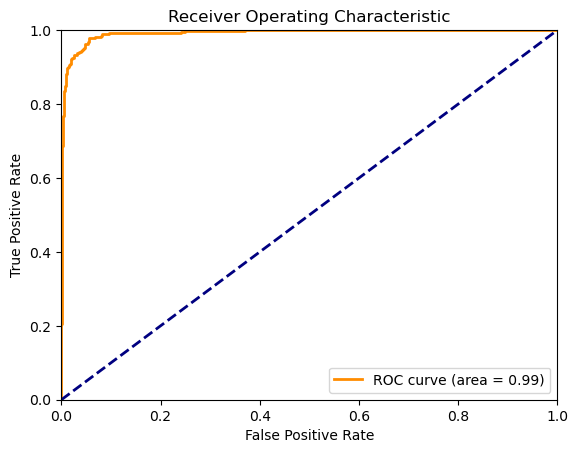

In [11]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

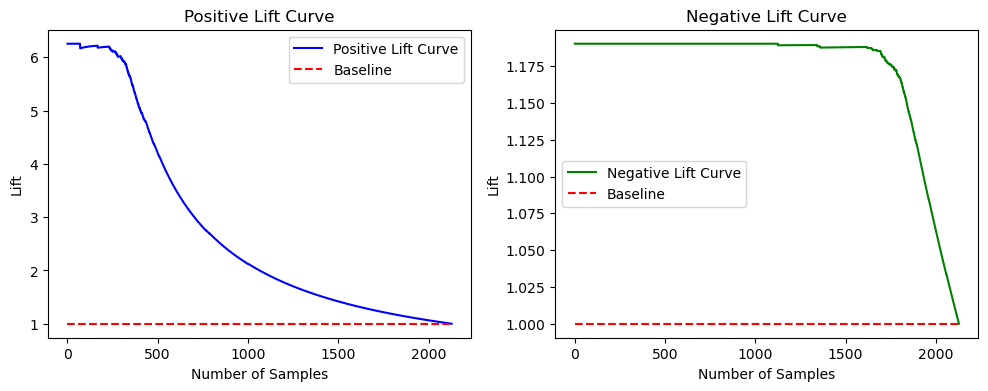

In [12]:
# Plot the lift curves
plot_lift_curves(y_test, y_pred_prob)

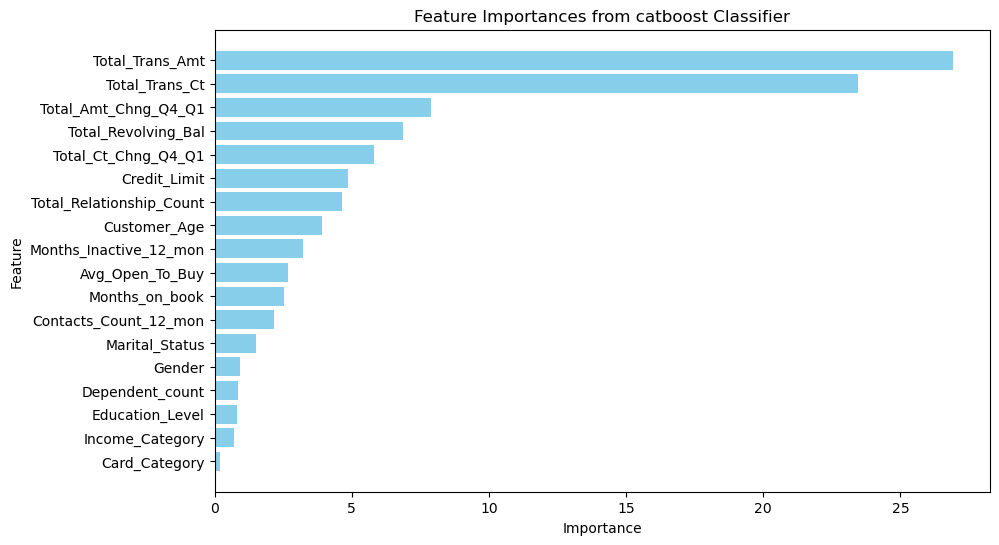

In [13]:
# Get feature importances
#classifier = best_model.named_steps['classifier']
feature_importances = cbc.feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['feature'], feature_importances_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from catboost Classifier')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()